In [4]:
import numpy as np
import pandas as pd
import os
import glob
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import hsv_to_rgb

import qtl.annotation
import qtl.plot
import qtl.torus
import style

annot = qtl.annotation.Annotation('../data/gencode.v26.GRCh38.genes.gtf', verbose=False)
sample_df = pd.read_csv('../code/workflow/submodules/gtex-v8/data/GTEx_Analysis_v8_RNAseq_samples.txt', sep='\t')
sample_s = sample_df[sample_df['has_genotype']].groupby('tissue_id').apply(lambda x: x['sample_id'].tolist())
sample_s = sample_s[sample_s.apply(len)>=70]
size_s = sample_s.apply(len)

In [3]:
os.chdir("/project/yangili1/cdai/splice-pub/analysis")

In [5]:
# VEP annotation for top eQTL/sQTL
vep_df = pd.read_csv('../data/WGS_Feature_overlap_collapsed_VEP_short_4torus.MAF01.txt.gz', sep='\t', index_col=0)
vep_df = vep_df.astype(np.int8)
vep_df.columns = [qtl.torus.torus_dict[i[:-2].upper()] for i in vep_df.columns]

# variant IDs for each category
variant_sets = {}
for p in vep_df:
    variant_sets[p] = set(vep_df.loc[vep_df[p]==1].index)
variant_set_s = pd.Series(variant_sets)

In [6]:
# check length of variant_sets
variant_sets.keys()
len(variant_sets.get('Enhancer'))
len(variant_sets.get("5' UTR variant"))
list(variant_sets.get("5' UTR variant"))[:5]

dict_keys(['Enhancer', 'Promoter', 'Open chromatin region', 'Promoter-flanking region', 'CTCF binding site', 'TF binding site', "3' UTR variant", "5' UTR variant", 'Frameshift variant', 'Intron variant', 'Missense variant', 'Non-coding transcript exon variant', 'Splice acceptor variant', 'Splice donor variant', 'Splice region variant', 'Stop gained', 'Synonymous variant'])

82219

29762

['chr6_125781340_C_G_b38',
 'chr8_115623645_T_TA_b38',
 'chr10_92691973_C_A_b38',
 'chrX_49164178_G_T_b38',
 'chr8_33513467_A_G_b38']

### Panel A: *cis*-QTLs

In [7]:
# annot.genes is a numpy array, I want to take a peek of its content

len(annot.gene_ids)
annot.gene_ids[:5]

56200

array(['ENSG00000223972.5', 'ENSG00000227232.5', 'ENSG00000278267.1',
       'ENSG00000243485.5', 'ENSG00000237613.2'], dtype='<U24')

In [8]:
for k in annot.gene_ids[:5]:
    g = annot.gene_dict[k]
    print(g.id, g.name, g.type, g.chr, g.strand, g.start_pos, g.end_pos)

ENSG00000223972.5 DDX11L1 transcribed_unprocessed_pseudogene chr1 + 11869 14403
ENSG00000227232.5 WASH7P unprocessed_pseudogene chr1 - 14410 29553
ENSG00000278267.1 MIR6859-1 miRNA chr1 - 17369 17436
ENSG00000243485.5 MIR1302-2HG lincRNA chr1 + 29571 31109
ENSG00000237613.2 FAM138A lincRNA chr1 - 34554 36081


In [9]:
# eGenes and sGenes files
egene_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('../data/GTEx_Analysis_v8_eQTL/*.v8.egenes.txt.gz')}
sgene_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('../data/GTEx_Analysis_v8_sQTL/*.v8.sgenes.txt.gz')}
tissues = sorted(egene_files.keys())

# select a few tissues
# tissues = ['Liver', 'Brain_Cortex', 'Kidney_Cortex', 'Whole_Blood']


In [10]:

# annotate top eQTLs and sQTLs with variant categories
egene_variant_cat_df = []
sgene_variant_cat_df = []
for t in tissues:
    print('\rProcessing {}'.format(t), end='')
    egenes_df = pd.read_csv(egene_files[t], sep='\t', index_col=0)
    egenes_df['biotype'] = egenes_df.index.map(lambda x: annot.gene_dict[x].type)
    egenes_df = egenes_df[(egenes_df['qval']<=0.05) & egenes_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    variant_ids = egenes_df['variant_id'].values
    pct_s = variant_set_s.apply(lambda x: len([i for i in variant_ids if i in x]))
    pct_s.name = t
    egene_variant_cat_df.append(pct_s)

    sgenes_df = pd.read_csv(sgene_files[t], sep='\t', index_col=0)
    sgenes_df['biotype'] = sgenes_df['gene_id'].apply(lambda x: annot.gene_dict[x].type)
    sgenes_df = sgenes_df[(sgenes_df['qval']<=0.05) & sgenes_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    variant_ids = sgenes_df['variant_id'].values
    pct_s = variant_set_s.apply(lambda x: len([i for i in variant_ids if i in x]))
    pct_s.name = t
    sgene_variant_cat_df.append(pct_s)
    
egene_variant_cat_df = pd.concat(egene_variant_cat_df, axis=1)    
sgene_variant_cat_df = pd.concat(sgene_variant_cat_df, axis=1)    
egene_variant_cat_pct_df = egene_variant_cat_df / egene_variant_cat_df.sum(0)
sgene_variant_cat_pct_df = sgene_variant_cat_df / sgene_variant_cat_df.sum(0)

Processing Whole_Bloodtine_Terminal_Ileumctionia

In [11]:
egene_variant_cat_df

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
Enhancer,189,137,116,154,51,172,33,34,89,90,...,164,167,61,124,79,164,175,27,25,136
Promoter,1261,1068,630,1053,482,1377,207,362,554,651,...,1207,1341,440,808,745,1084,1337,267,238,1229
Open chromatin region,370,290,168,300,126,386,78,117,178,222,...,378,387,132,203,179,337,387,62,81,254
Promoter-flanking region,675,570,369,575,235,720,146,222,315,361,...,669,710,262,503,351,581,754,123,120,905
CTCF binding site,306,258,154,250,124,284,75,128,172,230,...,309,327,133,195,133,371,341,58,77,209
TF binding site,95,90,60,88,43,97,20,39,53,61,...,103,101,49,63,57,149,123,26,26,81
3' UTR variant,586,475,276,493,231,662,118,189,334,393,...,604,664,213,382,326,578,655,125,126,421
5' UTR variant,531,437,238,429,199,515,72,135,189,250,...,486,547,189,292,314,464,531,112,102,468
Frameshift variant,13,15,8,13,5,16,5,5,8,4,...,16,14,3,7,9,14,16,3,3,10
Intron variant,6487,5202,3462,5408,2607,6407,1494,2278,3466,4152,...,6453,7015,2635,4388,3674,7033,7195,1342,1402,5288


In [12]:
sgene_variant_cat_df.sum(0).head()
sgene_variant_cat_pct_df.head()

Adipose_Subcutaneous        4797
Adipose_Visceral_Omentum    3973
Adrenal_Gland               2152
Artery_Aorta                3434
Artery_Coronary             1923
dtype: int64

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
Enhancer,0.007922,0.008809,0.007435,0.007280,0.008320,0.009476,0.011658,0.008588,0.008889,0.007656,...,0.010621,0.008374,0.009179,0.009645,0.009132,0.010125,0.007740,0.008929,0.010980,0.010753
Promoter,0.068793,0.079789,0.081784,0.066977,0.076443,0.074923,0.080311,0.070611,0.074286,0.070335,...,0.067345,0.067606,0.079374,0.077546,0.078456,0.056189,0.069458,0.077381,0.069804,0.075963
Open chromatin region,0.026892,0.025422,0.025558,0.025917,0.022361,0.027104,0.027202,0.017176,0.017778,0.022010,...,0.025085,0.027982,0.023758,0.022377,0.021586,0.025956,0.024013,0.020833,0.018039,0.024974
Promoter-flanking region,0.042944,0.042789,0.043680,0.039895,0.039002,0.039665,0.041451,0.046756,0.040635,0.043541,...,0.043390,0.043913,0.038337,0.050540,0.035699,0.038791,0.039889,0.040179,0.037647,0.060007
CTCF binding site,0.016677,0.015605,0.019981,0.014851,0.014561,0.013222,0.020725,0.021947,0.021587,0.016746,...,0.021017,0.014297,0.012959,0.013117,0.017435,0.020964,0.018059,0.022321,0.019608,0.012487


In [48]:
egenes_df.columns
egenes_df.head()

Index(['gene_name', 'gene_chr', 'gene_start', 'gene_end', 'strand', 'num_var',
       'beta_shape1', 'beta_shape2', 'true_df', 'pval_true_df', 'variant_id',
       'tss_distance', 'chr', 'variant_pos', 'ref', 'alt', 'num_alt_per_site',
       'rs_id_dbSNP151_GRCh38p7', 'minor_allele_samples', 'minor_allele_count',
       'maf', 'ref_factor', 'pval_nominal', 'slope', 'slope_se', 'pval_perm',
       'pval_beta', 'qval', 'pval_nominal_threshold', 'log2_aFC',
       'log2_aFC_lower', 'log2_aFC_upper', 'biotype'],
      dtype='object')

,gene_name,gene_chr,gene_start,gene_end,strand,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,...,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,log2_aFC,log2_aFC_lower,log2_aFC_upper,biotype
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000238009.6,RP11-34P13.7,chr1,89295,129223,-,1807,1.01210,354.630,537.158,5.974450e-28,...,0.693059,0.056494,0.000100,1.059730e-25,3.024780e-25,0.000333,2.298749,2.013133,2.547666,lincRNA
ENSG00000228463.9,AP006222.2,chr1,257864,297502,-,2799,1.03450,466.874,522.949,1.932970e-04,...,-0.533788,0.132736,0.075493,7.819130e-02,3.787400e-02,0.000269,-2.267305,-6.643856,-1.033481,lincRNA
ENSG00000237491.8,RP11-206L10.9,chr1,778770,810060,+,4834,1.01838,759.415,530.640,1.468930e-23,...,1.026590,0.091948,0.000100,4.757680e-21,1.099550e-20,0.000158,1.450466,1.255606,1.626524,lincRNA
ENSG00000177757.2,FAM87B,chr1,817371,819837,+,4893,1.05708,823.141,535.312,1.160180e-06,...,0.627772,0.120550,0.000400,6.258900e-04,4.408980e-04,0.000162,1.080225,0.766324,1.366386,lincRNA
ENSG00000225880.5,LINC00115,chr1,826206,827522,-,4907,1.04771,766.544,524.692,3.418240e-27,...,0.780427,0.063819,0.000100,1.924370e-25,5.441130e-25,0.000169,1.132230,0.999367,1.282875,lincRNA


In [55]:
# mean and s.d. of variant categories across tissues
mean_df = pd.concat([
    egene_variant_cat_pct_df.mean(1),
    sgene_variant_cat_pct_df.mean(1)
], axis=1)
mean_df.columns = ['eQTL', 'sQTL']
mean_df.rename(index=qtl.torus.torus_short_dict, inplace =True)

std_df = pd.concat([
    egene_variant_cat_pct_df.std(1),
    sgene_variant_cat_pct_df.std(1)
], axis=1)
std_df.columns = ['eQTL', 'sQTL']
std_df.rename(index=qtl.torus.torus_short_dict, inplace=True)

In [62]:
sqtl_tissue_avg_df.shape
eqtl_tissue_avg_df.shape


(17, 3)

(17, 3)

In [56]:
# load Torus outputs for eQTLs and sQTLs
eqtl_lor_df = qtl.torus.load_summary('../code/workflow/submodules/gtex-v8/data/GTEx_Analysis_v8_eQTL.torus_enrichment.txt', log2=True)
sqtl_lor_df = qtl.torus.load_summary('../code/workflow/submodules/gtex-v8/data/GTEx_Analysis_v8_sQTL.torus_enrichment.txt', log2=True)
eqtl_lor_df.drop(['Kidney_Cortex'], axis=1, inplace=True)
sqtl_lor_df.drop(['Kidney_Cortex'], axis=1, inplace=True)

# average across tissues: cis-eQTLs
m = (2**eqtl_lor_df).mean(1)
s = (2**eqtl_lor_df).std(1)
eqtl_tissue_avg_df = np.log2(pd.concat([m, m-s, m+s], axis=1))
eqtl_tissue_avg_df.columns = ['mean', 'std_low', 'std_high']
eqtl_tissue_avg_df.rename(index=qtl.torus.torus_short_dict, inplace=True)

# average across tissues: cis-sQTLs
m = (2**sqtl_lor_df).mean(1)
s = (2**sqtl_lor_df).std(1)
sqtl_tissue_avg_df = np.log2(pd.concat([m, m-s, m+s], axis=1))
sqtl_tissue_avg_df.columns = ['mean', 'std_low', 'std_high']
sqtl_tissue_avg_df.rename(index=qtl.torus.torus_short_dict, inplace=True)

In [72]:
# torus
eqtl_lor_df.head()

sqtl_tissue_avg_df.head() # log2 enrichment
mean_df.head() # proportion

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
feature_id,,,,,,,,,,,,,,,,,,,,,
Enhancer,1.359019,1.198880,1.507616,1.292655,1.015657,1.240718,0.377986,0.288539,0.561208,0.243815,...,0.805024,0.805024,0.536683,1.138286,0.686723,0.699707,0.995460,0.451564,-0.220732,1.346034
Promoter,1.383545,1.374888,1.327279,1.425383,1.292655,1.543684,0.880044,0.920439,1.021428,1.206093,...,1.312852,1.301311,1.112318,1.335936,1.289769,0.747316,1.217635,1.227733,1.133958,1.625917
Open chromatin region,0.644885,0.565536,0.431366,0.755972,0.227946,0.719905,-0.236602,0.036067,0.318836,0.238045,...,0.561208,0.561208,-0.043281,0.154368,0.092332,0.096661,0.328934,-0.217847,-0.432809,0.350575
Promoter-flanking region,0.721348,0.786269,0.790597,0.758858,0.432809,0.764628,0.380871,0.264013,0.369330,0.281326,...,0.620359,0.680952,0.450121,0.890143,0.497730,0.098103,0.637671,0.311622,0.255357,1.651886
CTCF binding site,-0.594390,-0.476089,-0.709806,-0.504943,-0.259685,-0.471761,-0.204863,0.178894,-0.541011,-0.429923,...,-0.344804,-0.712691,-0.382314,-0.607375,-0.644885,-0.232274,-0.435694,-0.497730,-0.487631,-0.770399


,mean,std_low,std_high
feature_id,,,
Enhancer,0.310085,-0.003145,0.567292
Promoter,-0.285583,-0.397825,-0.181447
Open chromatin,-0.244861,-0.487409,-0.037282
Promoter-flanking,-0.332649,-0.550822,-0.143177
CTCF binding site,-1.054247,-1.680616,-0.618943


,eQTL,sQTL
Enhancer,0.013273,0.008852
Promoter,0.103287,0.073607
Open chromatin,0.029120,0.024199
Promoter-flanking,0.055833,0.041868
CTCF binding site,0.026637,0.017546


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

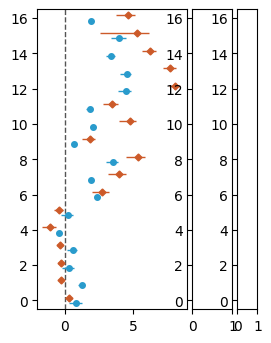

In [67]:
eargs = {'fmt':'.', 'ms':8,   'lw':1, 'clip_on':False, 'c':style.qtl_color_s['eqtl'], 'label':'eQTL'}
sargs = {'fmt':'D', 'ms':3.5, 'lw':1, 'clip_on':False, 'c':style.qtl_color_s['sqtl'], 'label':'sQTL'}
plot_enrichment(eqtl_tissue_avg_df, sqtl_tissue_avg_df, mean_df, std_df, eargs, sargs)
 # plt.savefig('pdfs/Fig4A_torus_enrichment_summary.pdf')

In [57]:
def plot_enrichment(df1, df2, varmean_df, varstd_df, args1, args2, legend_title=None):
    dl = 1.25
    aw1 = 1.5
    ds = 0.05
    aw2 = 0.4
    dr = 0.5
    db = 0.75
    ah = 3/17*df1.shape[0]
    dt = 0.25
    aw3 = 0.2
    
    fw = dl + aw1 + ds + aw2 + aw3 + dr
    fh = db + ah + dt
    fig = plt.figure(facecolor=(1,1,1), figsize=(fw,fh))
    ax1 = fig.add_axes([dl/fw, db/fh, aw1/fw, ah/fh])
    ax2 = fig.add_axes([(dl+aw1+ds)/fw, db/fh, aw2/fw, ah/fh], sharey=ax1)
    ax3 = fig.add_axes([(dl+aw1+ds+aw2+0.05)/fw, db/fh, aw3/fw, ah/fh], sharey=ax1)

    y = np.arange(df1.shape[0])
    ax1.set_ylim([y[0]-0.5, y[-1]+0.5])
    
    qtl.plot.plot_effects([df1, df2], [args1, args2],
                 xspace=[1.25,2,0.5], yspace=[0.5,ah,0.25], xlim=[-2,9],
                 xlabel='log$\mathregular{_{2}}$(Fold enrichment)', ylabel=None, ax=ax1)

    ax1.set_yticks(y)
    ax1.set_yticklabels(df1.index)
    ax1.legend(title=legend_title, loc='upper right', ncol=1, labelspacing=0.33, 
               columnspacing=1, handletextpad=0, handlelength=1.66, borderpad=0.25, framealpha=1)
    for ax in [ax2, ax3]:
        plt.setp(ax.get_yticklabels(), visible=False);
        for line in ax.yaxis.get_ticklines():
            line.set_markersize(0) # tick length
            line.set_markeredgewidth(0) # tick line width
    ax2.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    # plot proportion of variants
    varmean_df.plot(kind='barh', xerr=1.96*varstd_df, ax=ax2, legend=False, width=0.66, 
                 color=[args1['c'], args2['c']])
    varmean_df.plot(kind='barh', xerr=1.96*varstd_df, ax=ax3, legend=False, width=0.66, 
                 color=[args1['c'], args2['c']])

    ax2.set_xlim([0,0.12])
    ax2.set_xticks([0,0.1]) 
    ax3.set_xlim([0.5, 0.62])
    ax3.set_xticks([0.5,0.6])
    ax2.set_xticklabels([0,0.1], ha='center', fontsize=8)
    ax3.set_xticklabels([0.5,0.6], ha='left', fontsize=8)
    ax2.set_xlabel('Proportion\n of variants', ha='left')

    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, min_n_ticks=5, nbins=4))
    cis_xlim = ax1.get_xlim()
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()

---

# Below use R

In [13]:
library(tidyverse)
library(data.table)
library(bedtoolsr)

In [4]:
setwd('/project/yangili1/cdai/splice-pub/analysis')

In [6]:
tissues = c('Liver')
sgene_files = glue::glue('../code/results/qtl/noisy/GTEx/{tissues}/separateNoise/cis_100000/perm/chr{1:22}.addQval.txt.gz')

In [7]:
sgene_files

../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr1.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr2.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr3.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr4.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr5.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr6.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr7.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr8.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr9.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr10.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr11.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr12.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr13.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr14.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr15.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr16.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr17.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr18.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr19.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr20.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr21.addQval.txt.gz
../code/results/qtl/noisy/GTEx/Liver/separateNoise/cis_100000/perm/chr22.addQval.txt.gz

In [8]:
sgene_df <- map_dfr(sgene_files, fread)

In [11]:
sgene_df <- sgene_df[q < .05 & str_detect(phenotype_id, "UP|PR")]

In [12]:
sgene_df %>% dim()
sgene_df %>% head()

[1] 3570   21

phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,dof_true,dof_est,beta_ml1,beta_ml2,pval_nom,pval_r2,slope,pval_emp,pval_adj,q
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:1082987:1084352:clu_1808_-:PR,chr1,1082988,1084352,-,596,3532,chr1_1079456_A_G_b38,chr1,1079456,⋯,206,169.900,1.029230,52.6246,4.72618e-07,0.1161460,-0.362335,0.000999001,1.95822e-04,0.00517610
chr1:1090428:1091471:clu_1810_-:PR,chr1,1090429,1091471,-,604,0,chr1_1091327_C_A_b38,chr1,1091327,⋯,206,170.473,1.063910,60.7541,4.72455e-08,0.1350960,-0.444126,0.000999001,2.10856e-05,0.00068731
chr1:1217688:1218457:clu_1814_-:PR,chr1,1217689,1218457,-,594,0,chr1_1217733_G_A_b38,chr1,1217733,⋯,206,180.823,0.985867,64.7615,9.74565e-07,0.1101270,0.604832,0.000999001,3.28634e-04,0.00826580
chr1:1217804:1218457:clu_1814_-:PR,chr1,1217805,1218457,-,594,72,chr1_1217733_G_A_b38,chr1,1217733,⋯,206,173.863,1.058870,59.4772,8.34233e-07,0.1114230,-0.615276,0.000999001,2.18888e-04,0.00572330
chr1:1389047:1390229:clu_1835_-:UP,chr1,1389048,1390229,-,467,-63641,chr1_1453870_A_C_b38,chr1,1453870,⋯,206,178.993,0.968296,37.6122,1.38712e-05,0.0878077,-0.568726,0.002997000,2.37384e-03,0.04552800
chr1:1642001:1642346:clu_1843_-:PR,chr1,1642002,1642346,-,428,32112,chr1_1609890_C_T_b38,chr1,1609890,⋯,206,172.917,0.953546,40.0320,1.90325e-06,0.1045350,-0.540764,0.001998000,7.42839e-04,0.01646200
